/opt/conda/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Number of bands: 12


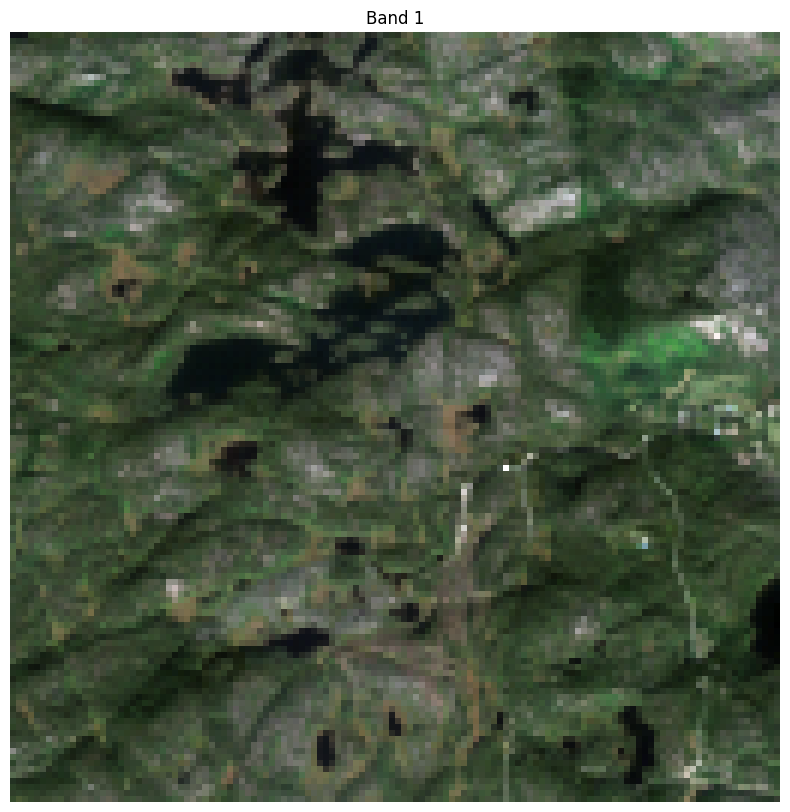

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Open the 12-band TIFF image using rasterio
file_path = '/kaggle/input/satalite-data/data/images/0.tif'  # Replace with the path to your TIFF image
with rasterio.open(file_path) as dataset:
    print(f'Number of bands: {dataset.count}')  # Should show 12 bands
    
    # Read 3 bands and map them to RGB (customize band selection based on your data)
    red_band = dataset.read(4)   # Use NIR band (example)
    green_band = dataset.read(3) # Use Red band (example)
    blue_band = dataset.read(2)  # Use Green band (example)
    
    # Normalize the bands for display (values between 0 and 1)
    def normalize(band):
        return (band - band.min()) / (band.max() - band.min())
    
    red = normalize(red_band)
    green = normalize(green_band)
    blue = normalize(blue_band)
    
    # Stack the bands together to create an RGB image
    rgb_image = np.dstack((red, green, blue))
    # Plot the three bands as a composite image
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_image, cmap='gray')  # Display one band (you can adjust)
    plt.title('Band 1')
    plt.axis('off')
    plt.show()

Number of bands: 12


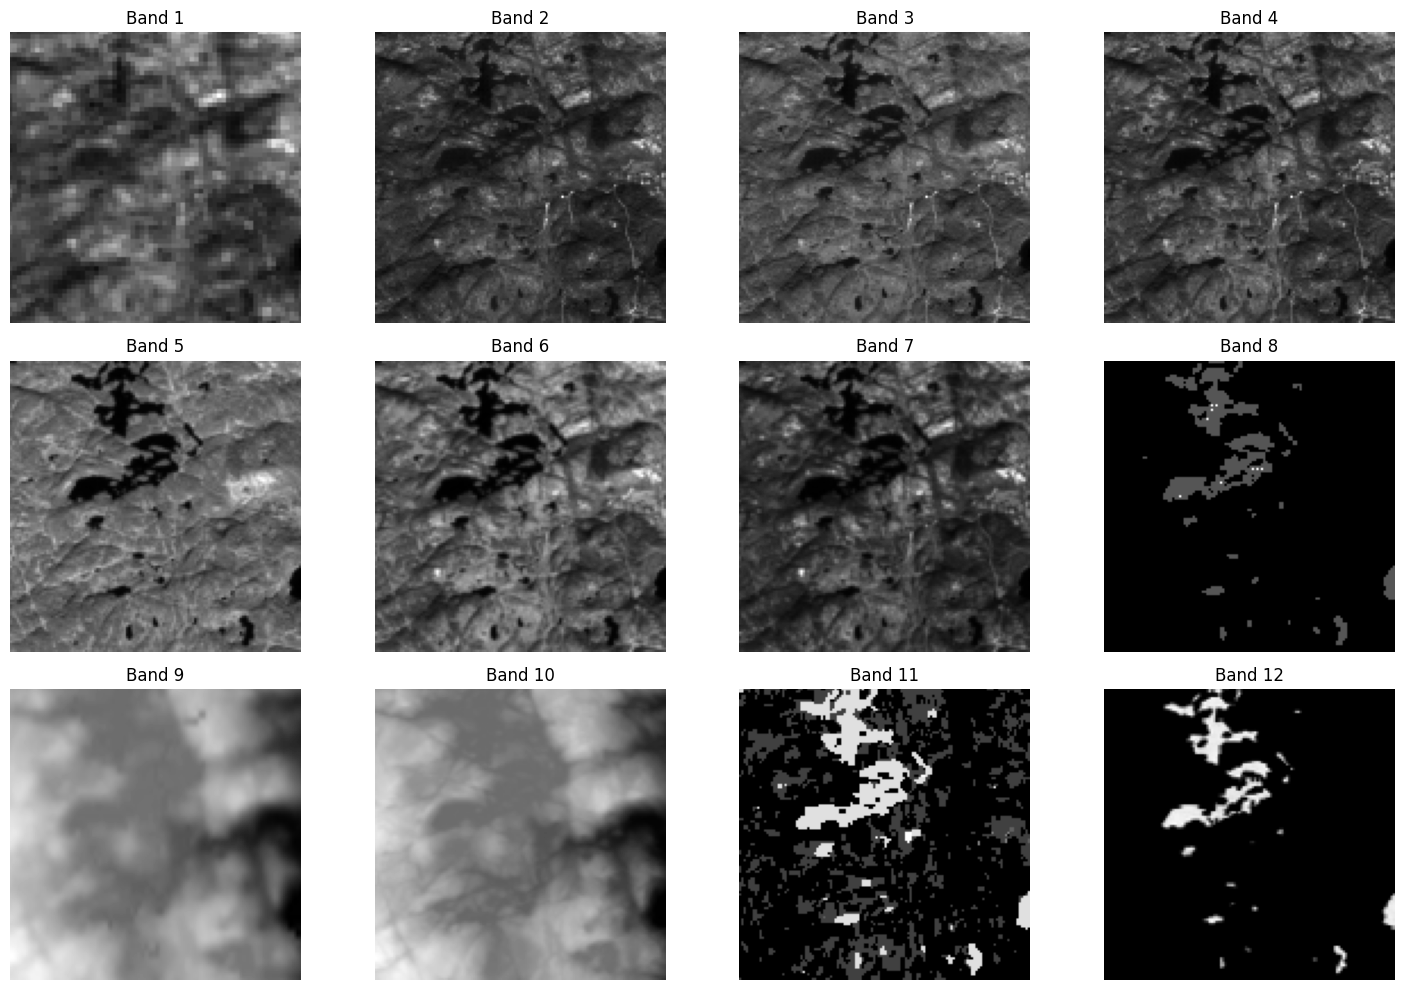

In [2]:
with rasterio.open(file_path) as dataset:
    print(f'Number of bands: {dataset.count}')  # Should show 12 bands
    
    # Create a figure with subplots (3x4 grid for 12 bands)
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    
    for i in range(1, dataset.count + 1):  # Loop through all 12 bands
        band = dataset.read(i)  # Read each band
        
        # Select the appropriate subplot (i-1) because subplots are 0-indexed
        ax = axes[(i-1) // 4, (i-1) % 4]
        
        # Display each band as a grayscale image
        ax.imshow(band, cmap='gray')
        ax.set_title(f'Band {i}')
        ax.axis('off')  # Hide axes for a cleaner look
    
    plt.tight_layout()
    plt.show()

In [3]:
import cv2

def load_tiff_image(image_path):
    with rasterio.open(image_path) as src:
        # Read all 12 bands
        image = np.stack([src.read(i) for i in range(1, 13)], axis=-1)
    return image

def load_png_mask(mask_path):
    # Load the mask as grayscale
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    # Normalize the mask to [0, 1]
    mask = mask / 255.0
    return mask

In [4]:
from sklearn.model_selection import train_test_split
# Example function to preprocess images and masks

def preprocess_data(image_size=(256, 256)):
    X = []
    y = []

    for i in range(0,306):
        image = load_tiff_image('/kaggle/input/satalite-data/data/images/'+str(i)+'.tif')
        mask = load_png_mask('/kaggle/input/satalite-data/data/labels/'+str(i)+".png")

        # Resize to match the U-Net input size
        image_resized = cv2.resize(image, image_size)
        mask_resized = cv2.resize(mask, image_size)

        X.append(image_resized)
        y.append(mask_resized)

    X = np.array(X)
    y = np.array(y)
    y = np.expand_dims(y, axis=-1)  # Add channel dimension to masks
    

    return X, y

# Preprocess data
X, y = preprocess_data()
y_ = (y > 0).astype(int)
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_, test_size=0.2, random_state=42)

#---Normalization 

def normalize_image(image):
    # Normalize each band to [0, 1]
    return (image - np.min(image)) / (np.max(image) - np.min(image))

X_train = np.array([normalize_image(img) for img in X_train])
X_val = np.array([normalize_image(img) for img in X_val])

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

# Apply the augmentation only to the training set
train_generator = datagen.flow(X_train, y_train, batch_size=8)

/opt/conda/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (244, 256, 256, 12) (12 channels).
  warnings.warn(


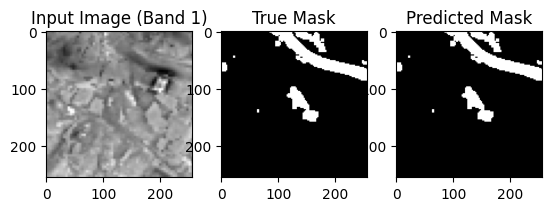

In [5]:
import matplotlib.pyplot as plt
plt.subplot(1, 3, 1)
plt.imshow(X[99][:, :, 0], cmap='gray')  # Display the first band
plt.title('Input Image (Band 1)')

plt.subplot(1, 3, 2)
plt.imshow(y_[99][:, :, 0], cmap='gray')  # True mask
plt.title('True Mask')

plt.subplot(1, 3, 3)
plt.imshow(y_[99][:, :, 0], cmap='gray')  # Predicted mask
plt.title('Predicted Mask')

plt.show()

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Input
from tensorflow.keras.models import Model

def unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)  # 1 channel output for binary classification

    model = Model(inputs, outputs)
    return model

# Input shape (height, width, channels), adjust height and width accordingly
input_shape = (256, 256, 12)
model = unet_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 256, 256,  │      6,976 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_57[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 128, 128,  │          0 │ conv2d_58[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_59[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 64, 64,    │          0 │ conv2d_60[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_13… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_61[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 32, 32,    │          0 │ conv2d_62[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_14… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_63[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 16, 16,    │          0 │ conv2d_64[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_15… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 16, 16,    │  9,438,208 │ conv2d_65[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_12    │ (None, 32, 32,    │          0 │ conv2d_66[0][0]   │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 32, 32,    │          0 │ up_sampling2d_12

 Total params: 31,384,129 (119.72 MB)

 Trainable params: 31,384,129 (119.72 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)


In [18]:
res = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, batch_size=8)

Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 381ms/step - accuracy: 0.7529 - loss: 22.3032 - val_accuracy: 0.6888 - val_loss: 0.4743
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.7461 - loss: 0.4817 - val_accuracy: 0.8703 - val_loss: 0.3869
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.8609 - loss: 0.3880 - val_accuracy: 0.8984 - val_loss: 0.3603
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.8560 - loss: 0.3916 - val_accuracy: 0.8978 - val_loss: 0.3317
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.8774 - loss: 0.3524 - val_accuracy: 0.8968 - val_loss: 0.2954
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.8789 - loss: 0.3158 - val_accuracy: 0.9045 - val_loss: 0.2671
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.8917 - loss: 0.2863 - val_accuracy: 0.9053 - val_loss: 0.2656
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.8858 - loss: 0.2918 - val_accuracy: 

In [20]:
model.save('model_2.h5')

In [ ]:
y_pred = model.predict(X_val)

In [ ]:
# Visualize a prediction
y_pred_th = (y_pred>0.41).astype(int)
import matplotlib.pyplot as plt
t_num = 12
plt.subplot(1, 3, 1)
plt.imshow(X_val[t_num][:, :, 0], cmap='gray')  # Display the first band
plt.title('Input Image (Band 1)')

plt.subplot(1, 3, 2)
plt.imshow(y_val[t_num][:, :, 0], cmap='gray')  # True mask
plt.title('True Mask')

plt.subplot(1, 3, 3)
plt.imshow(y_pred_th[t_num][:, :, 0], cmap='gray')  # Predicted mask
plt.title('Predicted Mask')

# plt.subplot(1, 4, 4)
# plt.imshow(y[t_num][:, :, 0], cmap='gray')  # Predicted mask
# plt.title('ori Mask')

plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve
y_pred_flat = y_pred.flatten()
y_val_flat = y_val.flatten()
# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val_flat, y_pred_flat)

# Calculate F1 scores for different thresholds
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")


In [ ]:
y_val

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

# Assuming y_true and y_pred are flattened binary arrays for evaluation (1 for water, 0 for non-water)
y_val_flat = y_val.flatten()
y_pred_th_flat = y_pred_th.flatten()
# Calculate IoU (Jaccard index)
iou = jaccard_score(y_val_flat, y_pred_th_flat, pos_label=1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_val_flat, y_pred_th_flat, pos_label=1)
recall = recall_score(y_val_flat, y_pred_th_flat, pos_label=1)
f1 = f1_score(y_val_flat, y_pred_th_flat, pos_label=1)

print(f"IoU for water class: {iou:.4f}")
print(f"Precision for water class: {precision:.4f}")
print(f"Recall for water class: {recall:.4f}")
print(f"F1-score for water class: {f1:.4f}")
